## imports

In [281]:
# from __future__ import division
import numpy as np
import pandas as pd
from string import digits
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import entropy
from scipy.spatial.distance import cdist
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import hypertools as hyp
import scipy
import numpy as np
import os

%matplotlib inline
sns.set_context('talk')

## set paths

In [2]:
vid_transc_dir = '../video transcript analysis'
answers_dir = '../graded_answers/'

## load lesson and question data

In [3]:
# Four forces
forces_video_df = pd.read_csv(os.path.join(vid_transc_dir,'fourforcesdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])

# already formatted as sliding windows
forces_video_samples = forces_video_df[0].tolist()

In [7]:
# birth of stars
bos_video_df = pd.read_csv(os.path.join(vid_transc_dir, 'birthofstarsdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])

# already formatted as sliding windows
bos_video_samples = pd.Series(bos_video_df[0]).tolist()

In [8]:
# questions
questions_df = pd.read_csv('../data analysis/astronomyquestions.tsv', sep='\t', 
            names=['index', 'video', 'question', 'ans_A', 'ans_B', 'ans_C', 'ans_D'], index_col='index') 

forces_questions_samples = questions_df.loc[questions_df.video == 1].question.tolist()
bos_questions_samples = questions_df.loc[questions_df.video == 2].question.tolist()
general_question_samples = questions_df.loc[questions_df.video == 0].question.tolist()

In [166]:
# link question text to qID
question_dict = {qid : questions_df.loc[qid].question for qid in questions_df.index}

## load and format participant answer data

In [10]:
data_df = pd.read_csv(os.path.join(answers_dir, 'Graded_results_19s.csv'), index_col='Unnamed: 0')

In [113]:
# format as diction {participantID : data}
sub_data = dict()

for sub in data_df.participantID.unique():
    sub_data[sub] = data_df.loc[data_df.participantID == sub].drop('participantID', axis=1).reset_index(drop=True)

sub_data[1].head()

,correct?,qID,set,video
0,1,13,0,1
1,0,21,0,2
2,0,12,0,1
3,1,16,0,2
4,1,28,0,2


## define some functions

In [38]:
vec_params = {
    'max_df': 0.95,
    'min_df': 2,
    'max_features': 500,
    'stop_words': 'english'
}

lda_params = {
    'n_components': 20,
    'max_iter': 10,
    'learning_method': 'online',
    'learning_offset':50.,
    'random_state': 0
}

In [39]:
def model_lessons_questions(v_windows, q_windows, vec_params, lda_params):
    """
    Fit a topic model to video and question content, use it to transform videos and questions.
    Returns a tuple: (video topic proportions, question topic proportions, fit topic model)
    """
    
    # initialize count vectorizer
    tf_vectorizer = CountVectorizer(**vec_params)
    # fit the model
    tf_vectorizer.fit(v_windows+q_windows)

    # transform video windows
    video_tf = tf_vectorizer.transform(v_windows)

    # transform question samples
    questions_tf = tf_vectorizer.transform(q_windows)

    both_tf = tf_vectorizer.transform(v_windows+q_windows)

    # initialize topic model
    lda = LatentDirichletAllocation(**lda_params)

    # fit topic model to video and questions
    lda.fit(both_tf)

    # transform video
    video_topics = lda.transform(video_tf)

    # smooth video model
    video_topics = pd.DataFrame(video_topics).rolling(25).mean().loc[25:,:].values

    # transform questions
    questions_topics = lda.transform(questions_tf)
    
    return video_topics, questions_topics, lda


In [32]:
def reconstruct_trace(video_model, questions_model, acc):
    """
    Function that reconstructs memory trajectory based on video model and a set of correctly answered questions
    """
    
    def normalize(x):
        xs = x - np.min(x)
        return np.divide(xs, np.max(xs))
    
    def z2r(z):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
    
    def r2z(r):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
    
    def symmetric_KL(a, b, c=.00000000001):
        return np.divide(entropy(a+c,b+c)+entropy(b+c,a+c), 2)

    # compute timepoints by questions correlation matrix
    wz = 1-scipy.spatial.distance.cdist(video_model, questions_model, symmetric_KL)
    
    # add the minimum value
    wz-=np.min(wz)
    
    # divide by the max value
    wz/=np.max(wz)
    
    # sum over columns
    a = np.sum(wz, axis=1)
 
    # sum over columns for correct answers
    b = np.sum(wz[:, list(map(bool, acc))], axis=1)
    
    # divide b by a
    ba = np.array(np.divide(b,a), ndmin=2)
    
    # weight the model
    return video_model*ba.T

In [33]:
def pcorrect_msd(video_topics, subject, n_questions, n_perms, p_correct = [0, .05, .25, .50, .75, .95, 1]):
    """
    Function that computes the MSD between video and question models as a function of p(correct answer)
    """
    
    dist = []
    for pc in p_correct:
        dists = []
        for perm in range(n_perms):
            acc = np.random.binomial(1, pc, n_questions).astype(int)
            recon = forces_traces_by_sub[subject]
            dists.append(np.mean(video_topics-recon)**2)
        dist.append(dists)
    return dist

# _Four Forces_

### model lecture video and questions

In [40]:
forces_v_traj, forces_q_traj, forces_tm = model_lessons_questions(forces_video_samples, forces_questions_samples, 
                                                           vec_params, lda_params)

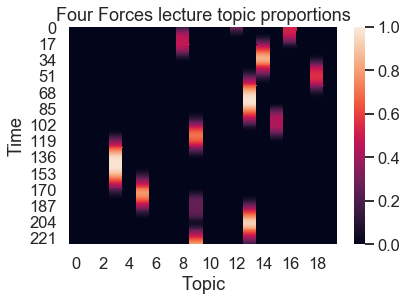

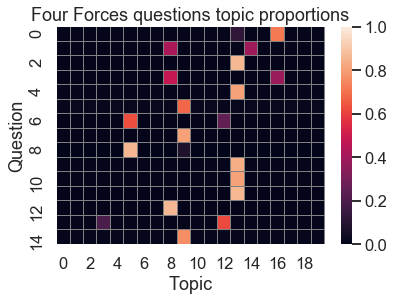

In [330]:
sns.heatmap(forces_v_traj, vmin=0, vmax=1)
plt.title('Four Forces lecture topic proportions')
plt.xlabel('Topic')
plt.ylabel('Time')
# plt.savefig('/Users/paxtonfitzpatrick/Desktop/forces-lecture-toppropsmat.pdf', bbox_inches='tight')
plt.show()

sns.heatmap(forces_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
plt.title('Four Forces questions topic proportions')
plt.xlabel('Topic')
plt.ylabel('Question')
# plt.savefig('/Users/paxtonfitzpatrick/Desktop/forces-questions-toppropsmat.pdf', bbox_inches='tight')
plt.show()

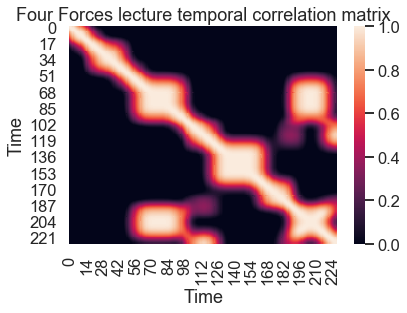

In [329]:
sns.heatmap(pd.DataFrame(forces_v_traj).T.corr(), vmin=0, vmax=1)
plt.title('Four Forces lecture temporal correlation matrix')
plt.xlabel('Time')
plt.ylabel('Time')
# plt.savefig('/Users/paxtonfitzpatrick/Desktop/forces-lecture-corrmat.pdf', bbox_inches='tight')
plt.show()

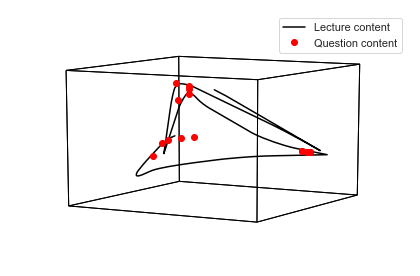

In [89]:
sns.set_context('notebook')
hyp.plot([forces_v_traj, forces_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
         legend=['Lecture content', 'Question content'])
plt.show()

### What moments of lecture content does each question cover?

In [652]:
sns.set_palette('hls')
sns.set_context('talk')

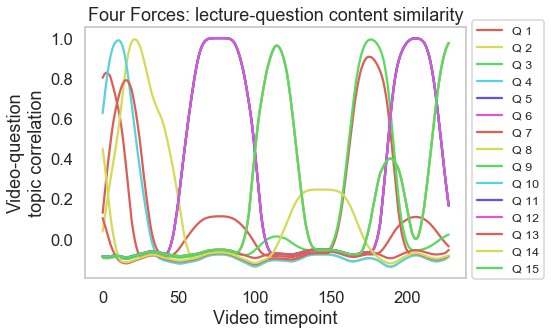

In [332]:
plt.figure(figsize=(8,5))
plt.plot(1-cdist(forces_v_traj, forces_q_traj, 'correlation'))
plt.xlabel('Video timepoint')
plt.ylabel('Video-question\ntopic correlation')
plt.title('Four Forces: lecture-question content similarity')
plt.legend(labels=[f'Q {i+1}' for i in range(forces_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1.05))
plt.grid(False)
# plt.savefig('/Users/paxtonfitzpatrick/Desktop/forces-v-q-similarity.pdf', bbox_inches='tight')
plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [215]:
forces_traces_set0 = {}
forces_traces_set1 = {}
forces_traces_set2 = {}

for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set0_fqs = df.loc[df.set == 0].loc[df.video == 1]
    # extract their topic vectors by index
    set0_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
    # get accuracy for those questions
    set0_fqs_acc = set0_fqs['correct?']
    
    forces_traces_set0[sid] = reconstruct_trace(forces_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set1_fqs = df.loc[df.set == 1].loc[df.video == 1]
    # extract their topic vectors by index
    set1_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
    # get accuracy for those questions
    set1_fqs_acc = set1_fqs['correct?']
    
    forces_traces_set1[sid] = reconstruct_trace(forces_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set2_fqs = df.loc[df.set == 2].loc[df.video == 1]
    # extract their topic vectors by index
    set2_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
    # get accuracy for those questions
    set2_fqs_acc = set2_fqs['correct?']
    
    forces_traces_set2[sid] = reconstruct_trace(forces_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [269]:
avg_force_trace0 = np.mean(list(forces_traces_set0.values()), axis=0)
avg_force_trace1 = np.mean(list(forces_traces_set1.values()), axis=0)
avg_force_trace2 = np.mean(list(forces_traces_set2.values()), axis=0)

In [517]:
sns.set_context('notebook')

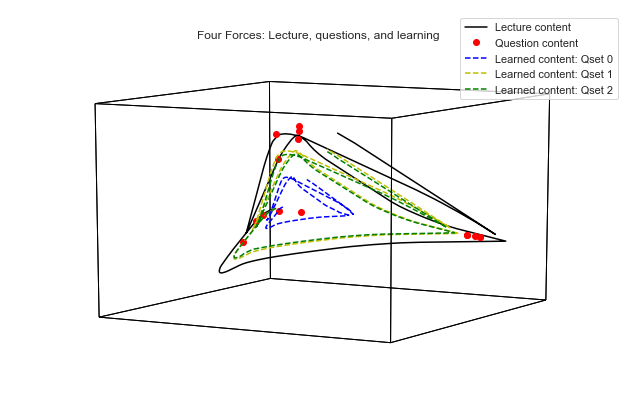

In [534]:
hyp.plot([forces_v_traj, forces_q_traj, avg_force_trace0, avg_force_trace1, avg_force_trace2], 
         fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6],
         title='Four Forces: Lecture, questions, and learning',
         legend=['Lecture content', 'Question content', 
                 'Learned content: Qset 0', 
                 'Learned content: Qset 1', 
                 'Learned content: Qset 2'])#, save_path='/Users/paxtonfitzpatrick/Desktop/forces-reconstructed.pdf')

# ax1.legend(labels = ['Lecture content', 'Question content', 
#                  'Learning trajectory: Qset 0', 
#                  'Learning trajectory: Qset 1', 
#                  'Learning trajectory: Qset 2'])

### How does the difference between viewed and learned content change after viewing the lecture?

In [451]:
# pairwise euclidean distance (slightly less exact than np.diag of scipy.spatial.distance.cdist)
def distance(x, y):
    return np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))

In [702]:
distances = np.array([np.diag(cdist(forces_v_traj, aft, metric='euclidean')) 
                      for aft in [avg_force_trace0, avg_force_trace1, avg_force_trace2]]).T

perfect = np.array([0 for i in range(forces_v_traj.shape[0])], ndmin=2).T

In [666]:
sns.set_palette('hls')
sns.set_style('ticks')

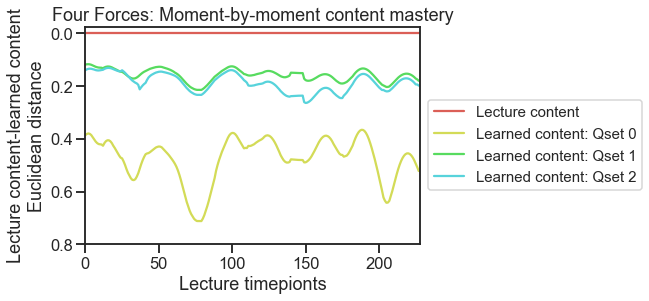

In [661]:
plt.plot(np.hstack([perfect, distances]))
plt.ylim(.8,-.025)
plt.xlim(0, forces_v_traj.shape[0])
plt.xlabel('Lecture timepionts')
plt.ylabel('Lecture content-learned content\nEuclidean distance')
plt.title('Four Forces: Moment-by-moment content mastery')
plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
                   'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
plt.savefig('/Users/paxtonfitzpatrick/Desktop/forces-lecture-trace-eucdist.pdf', bbox_inches='tight')
plt.show()

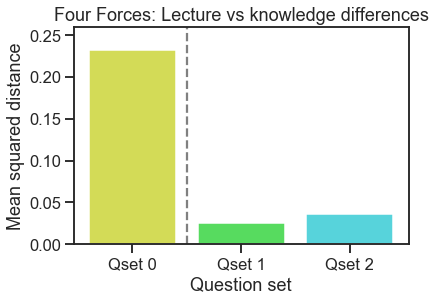

In [704]:
plt.bar(x=list(range(3)), height=(distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
       color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
plt.ylim(0,0.26)
plt.xlabel('Question set')
plt.ylabel('Mean squared distance')
plt.title('Four Forces: Lecture vs knowledge differences')
plt.vlines(x=.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# plt.savefig('/Users/paxtonfitzpatrick/Desktop/forces-msd-by-qset.pdf', bbox_inches='tight')
plt.show()

In [672]:
sns.hls_palette()

[(0.86, 0.3712, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999)]

# _Birth of Stars_

### model lecture video and questions

In [333]:
bos_v_traj, bos_q_traj, bos_tm = model_lessons_questions(bos_video_samples, bos_questions_samples, 
                                                           vec_params, lda_params)

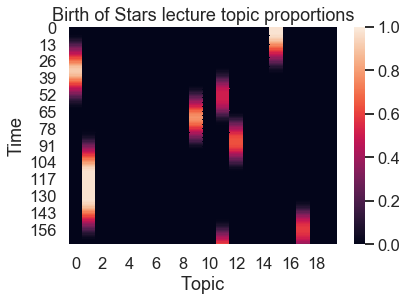

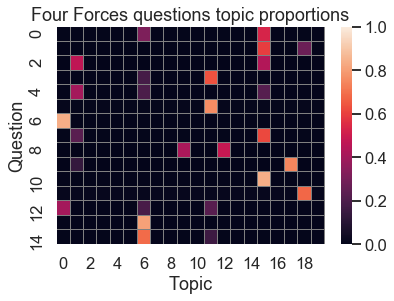

In [334]:
sns.heatmap(bos_v_traj, vmin=0, vmax=1)
plt.title('Birth of Stars lecture topic proportions')
plt.xlabel('Topic')
plt.ylabel('Time')
plt.savefig('/Users/paxtonfitzpatrick/Desktop/bos-lecture-toppropsmat.pdf', bbox_inches='tight')
plt.show()

sns.heatmap(bos_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
plt.title('Birth of Stars questions topic proportions')
plt.xlabel('Topic')
plt.ylabel('Question')
plt.savefig('/Users/paxtonfitzpatrick/Desktop/bos-questions-toppropsmat.pdf', bbox_inches='tight')
plt.show()

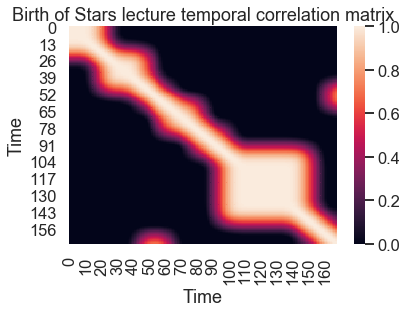

In [336]:
sns.heatmap(pd.DataFrame(bos_v_traj).T.corr(), vmin=0, vmax=1)
plt.title('Birth of Stars lecture temporal correlation matrix')
plt.xlabel('Time')
plt.ylabel('Time')
# plt.savefig('/Users/paxtonfitzpatrick/Desktop/bos-lecture-corrmat.pdf', bbox_inches='tight')
plt.show()

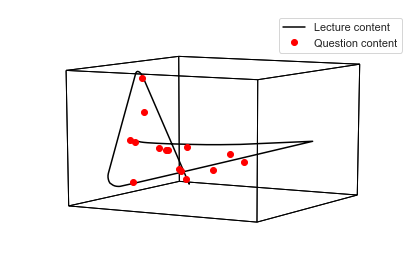

In [337]:
sns.set_context('notebook')
hyp.plot([bos_v_traj, bos_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
         legend=['Lecture content', 'Question content'])
plt.show()

### What moments of lecture content does each question cover?

In [339]:
sns.set_palette('hls')
sns.set_context('talk')

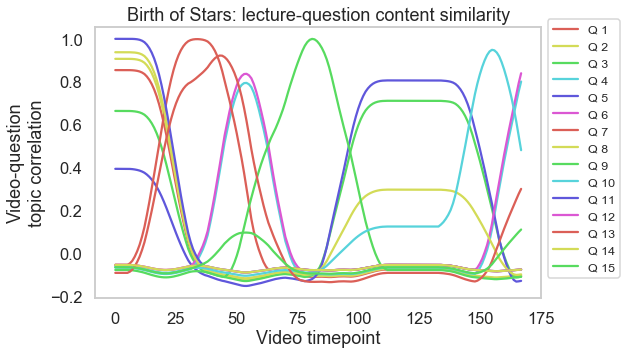

In [341]:
plt.figure(figsize=(8,5))
plt.plot(1-cdist(bos_v_traj, bos_q_traj, 'correlation'))
plt.xlabel('Video timepoint')
plt.ylabel('Video-question\ntopic correlation')
plt.title('Birth of Stars: lecture-question content similarity')
plt.legend(labels=[f'Q {i+1}' for i in range(bos_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1.05))
plt.grid(False)
# plt.savefig('/Users/paxtonfitzpatrick/Desktop/bos-v-q-similarity.pdf', bbox_inches='tight')
plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [342]:
bos_traces_set0 = {}
bos_traces_set1 = {}
bos_traces_set2 = {}

for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set0_fqs = df.loc[df.set == 0].loc[df.video == 2]
    # extract their topic vectors by index
    set0_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
    # get accuracy for those questions
    set0_fqs_acc = set0_fqs['correct?']
    
    bos_traces_set0[sid] = reconstruct_trace(bos_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set1_fqs = df.loc[df.set == 1].loc[df.video == 2]
    # extract their topic vectors by index
    set1_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
    # get accuracy for those questions
    set1_fqs_acc = set1_fqs['correct?']
    
    bos_traces_set1[sid] = reconstruct_trace(bos_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set2_fqs = df.loc[df.set == 2].loc[df.video == 2]
    # extract their topic vectors by index
    set2_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
    # get accuracy for those questions
    set2_fqs_acc = set2_fqs['correct?']
    
    bos_traces_set2[sid] = reconstruct_trace(bos_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [343]:
avg_bos_trace0 = np.mean(list(bos_traces_set0.values()), axis=0)
avg_bos_trace1 = np.mean(list(bos_traces_set1.values()), axis=0)
avg_bos_trace2 = np.mean(list(bos_traces_set2.values()), axis=0)

In [344]:
sns.set_context('notebook')

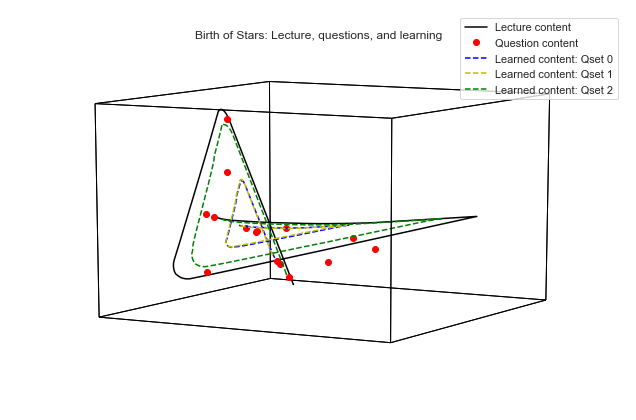

In [346]:
hyp.plot([bos_v_traj, bos_q_traj, avg_bos_trace0, avg_bos_trace1, avg_bos_trace2], 
         fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6],
         title='Birth of Stars: Lecture, questions, and learning',
         legend=['Lecture content', 'Question content', 
                 'Learned content: Qset 0', 
                 'Learned content: Qset 1', 
                 'Learned content: Qset 2'])#, save_path='/Users/paxtonfitzpatrick/Desktop/bos-reconstructed.pdf')

# ax1.legend(labels = ['Lecture content', 'Question content', 
#                  'Learning trajectory: Qset 0', 
#                  'Learning trajectory: Qset 1', 
#                  'Learning trajectory: Qset 2'])

### How does the difference between viewed and learned content change after viewing the lecture?

In [680]:
bos_distances = np.array([np.diag(cdist(bos_v_traj, abt, metric='euclidean')) 
                      for abt in [avg_bos_trace0, avg_bos_trace1, avg_bos_trace2]]).T

bos_perfect = np.array([0 for i in range(bos_v_traj.shape[0])], ndmin=2).T

In [681]:
sns.set_palette('hls')
sns.set_style('ticks')

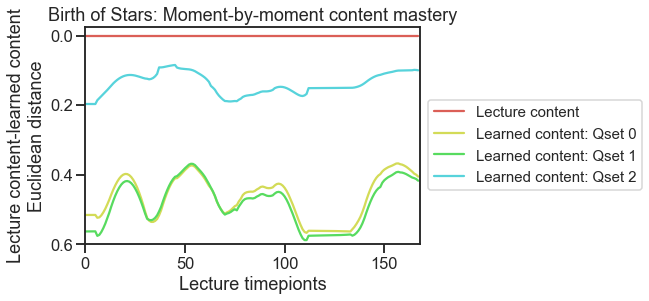

In [682]:
plt.plot(np.hstack([bos_perfect, bos_distances]))
plt.ylim(.6,-.025)
plt.xlim(0, bos_v_traj.shape[0])
plt.xlabel('Lecture timepionts')
plt.ylabel('Lecture content-learned content\nEuclidean distance')
plt.title('Birth of Stars: Moment-by-moment content mastery')
plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
                   'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
plt.savefig('/Users/paxtonfitzpatrick/Desktop/bos-lecture-trace-eucdist.pdf', bbox_inches='tight')
plt.show()

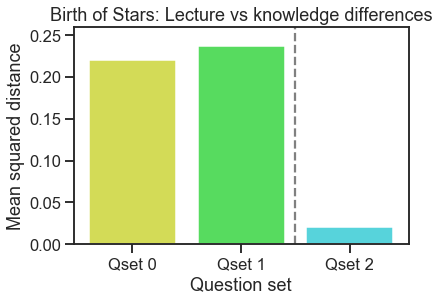

In [701]:
plt.bar(x=list(range(3)), height=(bos_distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
       color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
plt.ylim(0,0.26)
plt.xlabel('Question set')
plt.ylabel('Mean squared distance')
plt.title('Birth of Stars: Lecture vs knowledge differences')
plt.vlines(x=1.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
plt.savefig('/Users/paxtonfitzpatrick/Desktop/bos-msd-by-qset.pdf', bbox_inches='tight')
plt.show()